In [45]:
%matplotlib inline
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

from IPython.display import display

import re

In [60]:
col_names  = ["Street",  "Street_batch", "Street_cluster"]
filename = "blog_streets.csv.gz"


# filename = "Pays.xlsx"
# col_names = ["Pays", "Pays_clean"] 


# Functions

## Val_count

In [47]:
def get_val_count(filename, col_name):
    if ".csv" in filename: df = pd.read_csv(filename, usecols = [col_name])
    elif ".xlsx" in filename: 
        df = pd.read_excel(filename)
        df = df[[col_name]]
        
    else: df = pd.read_table(filename, usecols = [col_name])
    print(col_name, ":")
    
    print(" - Number of records: {} ({} non empty)".format(df.shape[0], df[df[col_name].fillna("").astype(str).str.len()>0].shape[0]))
    
    print(" - Number of (distinct) values: ", df[col_name].nunique())
    print(" - Number of empty values: ", df[df[col_name].fillna("").str.len()==0].shape[0])
    
    
    
    val_counts = df[col_name].value_counts().reset_index(drop=True).reset_index()
    val_counts["index"] = val_counts["index"]+1
    val_counts = val_counts.reset_index(drop = True)

    val_counts["cum_sum"] = val_counts[col_name].cumsum()
    
    first_one = val_counts[val_counts[col_name] == 1].first_valid_index()
    if first_one: 
        print(" - Number of 1's: ", val_counts["index"].max()-first_one +1)

    val_counts = val_counts.rename(columns={"index":"ValueId", "cum_sum":"#CumRecords", col_name:"#Records"}).set_index("ValueId")
    val_counts.name = col_name
    return val_counts
    

In [48]:
def plot_val_count(val_counts, ax=None, color="C0", rot=-45, scale_val= False, figsize=(15,10), stats = [10, 100, "med_y", "med_x", "p_90","t_1", "t_2", "max"], drawstyle="steps-post"):

    
    def add_lines(ax, val_counts, x, title):
        global all_xy_labels
        
        line_color = color 
        y = val_counts.loc[x]["#CumRecords"]
        

        ax.plot([x, x], [0, y], color=line_color, linestyle=':', marker='x', markevery=(1, 2), linewidth=1)
        ax.plot([0, x], [y, y], color=line_color, linestyle=':', linewidth=1)
        
        
        ax.text(x- max_x * 0.02 , y - np.sign(rot)*max_y * 0.02, "{} ({:.2f}%)".format(int(y), (y/max_y)*100), 
                color=color, ha='right', va="bottom" if rot<0 else "top", bbox=dict(facecolor='white', alpha=0.9,  edgecolor='none'), rotation=rot)
        
        ax.text(x, - max_y * 0.1, "{}: {} ({:.2f}%)".format(title, int(x), (x/max_x)*100), 
                color=color, ha='right', va="top", bbox=dict(facecolor='white', alpha=0.9,  edgecolor='none'), rotation=45)
       
        return ("{:12}".format(title), "{:6} ({:6.2f}%) /  {:6} ({:6.2f}%)".format(int(x), (x/max_x)*100,int(y), (y/max_y)*100))

    label = val_counts.name
    val_counts = pd.concat([pd.DataFrame({"ValueId":[0.99999], "#Records":[0], "#CumRecords":0}).set_index("ValueId"), val_counts], sort=False)#.reset_index(drop = True)
    
    
    if scale_val:
        val_counts = val_counts.set_index(val_counts.index/val_counts.index.max())
    max_x = val_counts.index.max()
    max_y = val_counts["#CumRecords"].max()
    
    if ax is None:
        xlim = (1 - max_x/20.0, max_x*1.05)
        
    else: 
        xlim = (min(ax.get_xlim()[0], 1 - max_x/20.0), max(ax.get_xlim()[1], max_x*1.05))
        
    
    ax = val_counts.plot(y="#CumRecords", figsize=figsize, ax=ax, color=color, label = label, drawstyle=drawstyle, xlim = xlim )
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    stat_legend = []
    for stat in stats: 
        m_perc = re.match("^p_([0-9]+)$", str(stat))
        m_tail = re.match("^t_([0-9]+)$", str(stat))
        
        if stat == "med_y":
            median_y = val_counts[val_counts["#CumRecords"] > val_counts["#CumRecords"].max()*0.5].first_valid_index()
            stat_legend.append(add_lines(ax, val_counts, median_y, "Median Y"))

        elif stat == "med_x":
            median_x = max_x // 2 # val_counts["index".shape[0]//2
            stat_legend.append(add_lines(ax, val_counts, median_x, "Median X"))


        elif m_perc:
            val = int(m_perc.group(1))
            perc_y = val_counts[val_counts["#CumRecords"] > val_counts["#CumRecords"].max()*val/100.0].first_valid_index()
            stat_legend.append(add_lines(ax, val_counts, perc_y, "Perc "+str(val)+"% (Y)"))


        elif stat == "max":
            stat_legend.append(add_lines(ax, val_counts, max_x, "Max"))

        elif m_tail:
            val = int(m_tail.group(1))

            tail = val_counts[val_counts["#Records"] == val].first_valid_index()
            if tail:
                 stat_legend.append(add_lines(ax, val_counts, tail, str(val)+"'s"))

        elif str(stat).isdigit():
            i = int(stat)
            if i < max_x:
                stat_legend.append(add_lines(ax, val_counts, i, str(i)))
        
    return ax, pd.DataFrame(columns=["stat", label], data=stat_legend).set_index("stat")


In [49]:
def plot_ratio(vc1, vc2, ax=None, op="div", figsize=None, color=None, xlim=None, xtics=None):

    vc_both = vc1[["#CumRecords"]].merge(vc2[["#CumRecords"]], right_index=True, left_index=True, how="outer")
    vc_both = vc_both.fillna(method='ffill')
    
    if op == "div":
        vc_both[op] =vc_both["#CumRecords_x"]/ vc_both["#CumRecords_y"]
        
    if op == "der": # kind of derivative
        
        vc_both[op] =(vc_both["#CumRecords_x"]- vc_both["#CumRecords_y"]).rolling(500).mean().diff(-50)

    elif op == "sub": 
        vc_both[op] =vc_both["#CumRecords_y"] -  vc_both["#CumRecords_x"]
    
    ax = vc_both.plot(y=op, ax=ax, figsize=figsize, label = "{} {} {}".format(vc1.name, "-" if op == "sub" else "vs ("+op+")", vc2.name) , color=color, 
                      xlim=xlim, ylim=(-50, None) if op=="der" else None)
    if xtics is not None:

        ax.set_xticks(xtics[1:-1])
    return ax


In [50]:
def compare_val_counts(vcs, stats = [10, 100, "med_y", "med_x", "p_90","t_1", "t_2", "max"]):
    fig, axes = plt.subplots(4, 1,  figsize=(10, 10), gridspec_kw = {'height_ratios':[5, 1, 2,2 ] }, squeeze=False)
    
    colors = ["C0", "C1", "C2", "C3", "C4", "C5"]
        
    
    stat_legends = None
    for i in range(len(vcs)):
        ax, stat_legend = plot_val_count(vcs[i], ax=axes[0,0], color = colors[i % len(colors)], figsize=None, stats = stats)

        stat_legends = stat_legend if stat_legends is None else stat_legends.merge(stat_legend, left_index=True, right_index=True, how= "outer")
        

    for i, vc in enumerate(vcs[1:]):
        
        
        plot_ratio(  vcs[i], vc, op="sub", ax= axes[2,0], color=colors[i+1], xlim = axes[0,0].get_xlim(), xtics = axes[0,0].get_xticks())
        
        plot_ratio(  vcs[0], vc, op="sub", ax= axes[3,0], color=colors[i+1], xlim = axes[0,0].get_xlim(), xtics = axes[0,0].get_xticks())
        
    
    plt.tight_layout()
    axes[1, 0].axis('off')
    
    axes[0, 0].set_zorder(100)
    
    return fig, stat_legends

## Val_count_distrib

In [51]:
def val_count_distrib(vc):
    vc = vc.groupby("#Records")["#Records"].sum()
    
    vc = vc.reindex(range(1, vc.index.max()+1)).fillna(0).astype(int)
    vc = vc.rename("nbrec").reset_index().rename(columns={"#Records": "#Values", "nbrec":"#Records"})
    vc["#DistinctValues"]= (vc["#Records"]/vc["#Values"]).astype(int)
    return vc
    

# Analysis

In [61]:
if ".csv" in filename: 
    df = pd.read_csv(filename, usecols = col_names)
elif ".xlsx" in filename: 
    df = pd.read_excel(filename, usecols = col_names)

else: df = pd.read_table(filename)

df

,Street,Street_batch,Street_cluster
0,Rue du Chêne,RUE DU CHÊNE,RUE DU CHÊNE
1,Place Madou,PLACE MADOU,PLACE MADOU
2,Avenue de l'Astronomie,AVENUE DE L'ASTRONOMIE,AVENUE DE L'ASTRONOMIE
3,Avenue de l'Astronomie,AVENUE DE L'ASTRONOMIE,AVENUE DE L'ASTRONOMIE
4,Boulevard du Roi AlbertII,BOULEVARD DU ROI ALBERTII,BOULEVARD DU ROI ALBERT II
5,Avenue Paul Hymans,AVENUE PAUL HYMANS,AVENUE PAUL HYMANS
6,Rue de Trèves,RUE DE TRÈVES,RUE DE TRÈVES
7,Boulevard Pachéco,BOULEVARD PACHÉCO,BOULEVARD PACHÉCO
8,Boulevard de l'Impératrice,BOULEVARD DE L'IMPÉRATRICE,BOULEVARD DE L'IMPÉRATRICE
9,Avenue du Maelbeek,AVENUE DU MAELBEEK,AVENUE DU MAELBEEK


In [62]:
print("Number of occurences per tuple of values : ") 
df[col_names].reset_index().groupby(col_names).count().sort_values("index", ascending=False)#.reset_index()

Number of occurences per tuple of values : 


,,,index
Street,Street_batch,Street_cluster,
Avenue Louise,AVENUE LOUISE,AVENUE LOUISE,6873
Chaussée de Waterloo,CHAUSSÉE DE WATERLOO,CHAUSSÉE DE WATERLOO,3254
Chaussée d'Alsemberg,CHAUSSÉE D'ALSEMBERG,CHAUSSÉE D'ALSEMBERG,2469
Chaussée de Wavre,CHAUSSÉE DE WAVRE,CHAUSSÉE DE WAVRE,2099
Avenue de Tervueren,AVENUE DE TERVUEREN,AVENUE DE TERVUEREN,1846
Chaussée de Mons,CHAUSSÉE DE MONS,CHAUSSÉE DE MONS,1544
Avenue Brugmann,AVENUE BRUGMANN,AVENUE BRUGMANN,1511
Chaussée de Haecht,CHAUSSÉE DE HAECHT,CHAUSSÉE DE HAECHT,1418
Chaussée de Gand,CHAUSSÉE DE GAND,CHAUSSÉE DE GAND,1386


In [63]:
print("Number of occurrence per columns")
for col_name in col_names:
    print(col_name, ":")
    display(df[col_name].value_counts().reset_index())
    print("\n\n")

Number of occurrence per columns
Street :


,index,Street
0,Avenue Louise,6873
1,Chaussée de Waterloo,3254
2,Chaussée d'Alsemberg,2469
3,Chaussée de Wavre,2099
4,Avenue de Tervueren,1846
5,Chaussée de Mons,1544
6,Avenue Brugmann,1511
7,Chaussée de Haecht,1418
8,Chaussée de Gand,1386
9,Chaussée de Louvain,1362





Street_batch :


,index,Street_batch
0,AVENUE LOUISE,7010
1,CHAUSSÉE DE WATERLOO,3259
2,CHAUSSÉE D'ALSEMBERG,2474
3,CHAUSSÉE DE WAVRE,2104
4,AVENUE DE TERVUEREN,1847
5,CHAUSSÉE DE MONS,1549
6,AVENUE BRUGMANN,1511
7,CHAUSSÉE DE HAECHT,1426
8,CHAUSSÉE DE GAND,1388
9,CHAUSSÉE DE LOUVAIN,1376





Street_cluster :


,index,Street_cluster
0,AVENUE LOUISE,7010
1,CHAUSSÉE DE WATERLOO,3263
2,CHAUSSÉE D'ALSEMBERG,2506
3,CHAUSSÉE DE WAVRE,2104
4,AVENUE DE TERVUEREN,1852
5,CHAUSSÉE DE MONS,1549
6,AVENUE BRUGMANN,1513
7,CHAUSSÉE DE HAECHT,1426
8,CHAUSSÉE DE GAND,1390
9,CHAUSSÉE DE LOUVAIN,1381


In [64]:
val_counts = []
for col_name in col_names:
    val_counts.append(get_val_count(filename, col_name))

Street :
 - Number of records: 266446 (263447 non empty)
 - Number of (distinct) values:  6867
 - Number of empty values:  2999
 - Number of 1's:  2129
Street_batch :
 - Number of records: 266446 (263446 non empty)
 - Number of (distinct) values:  6003
 - Number of empty values:  3000
 - Number of 1's:  1337
Street_cluster :
 - Number of records: 266446 (263446 non empty)
 - Number of (distinct) values:  5820
 - Number of empty values:  3000
 - Number of 1's:  1185


## Plots

,Street,Street_batch,Street_cluster
stat,,,
1's,4740 ( 69.03%) / 261320 ( 99.19%),4668 ( 77.76%) / 262111 ( 99.49%),4637 ( 79.67%) / 262263 ( 99.55%)
Max,6867 (100.00%) / 263447 (100.00%),6003 (100.00%) / 263446 (100.00%),5820 (100.00%) / 263446 (100.00%)


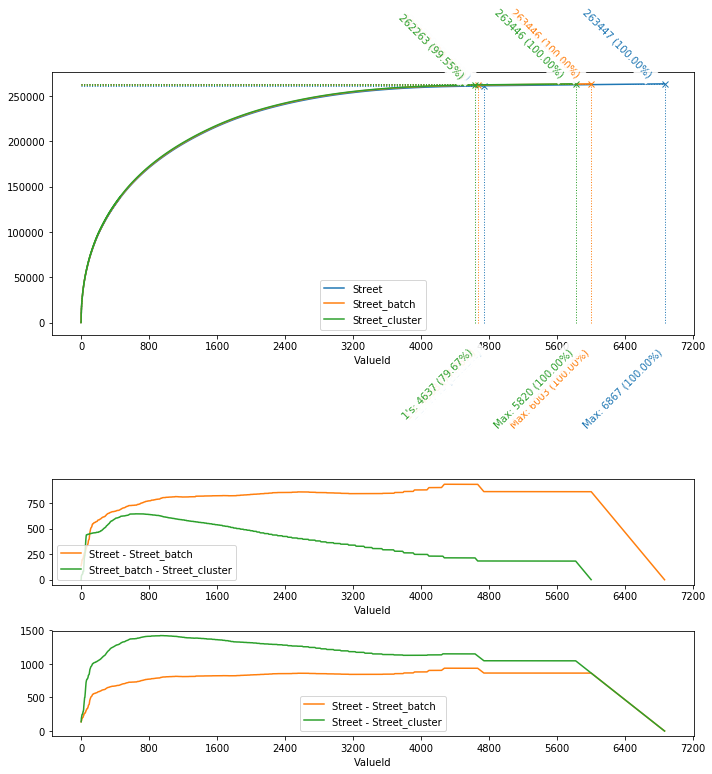

In [65]:
val_count_fig, val_count_tbl = compare_val_counts(val_counts, stats = ["t_1", "max"])
val_count_tbl.fillna("[NA]")

In [66]:
val_count_fig.savefig("plot.svg")
val_count_fig.savefig("plot.png")
